# Calibrating the IFT Cloud Mask
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values from band 7 and band 2 of the MODIS false color imagery (7-2-1). The true color imagery can also be helpful, which includes bands 1-4-3. The algorithm is equivalent to production of a bifurcation of the Band 2 to Band 7 color reflectance plane.

## Algorithm
Let the intensity value of band $i$ be given by $B_i$. The module then creates a binary mask with the following steps:
1. $A \gets $ Pixels with $B_7 > 110 = \tau_{0}$.
2. $B \gets $ Pixels with $B_7 < 200 = \tau_{b7}$ and $B_2 > 190 = \tau_{b2}$.
3. $C \gets$ Pixels with $B_7/B_2 < 0.75 = \tau_{R}$.
4. All clouds $\gets A$
5. Opaque clouds $\gets A \setminus (B \cap C)$

This algorithm is defined in Lopez-Acosta et al. 2019, with somewhat ambiguous wording regarding how sets $B$ and $C$ should be included. The algorithm defines a parameterized piecewise linear function partitioning B7 vs B2 space, with pixel reflectances on one side of the line classified as clouds, and on the other as cloud free (or thin cloud with sea ice). The cloud mask algorithm is quite flexible. I demonstrate a range of curves below.

[0, 255] [75, 75]
[0, 160, 160, 255] [90, 90, 100, 100]


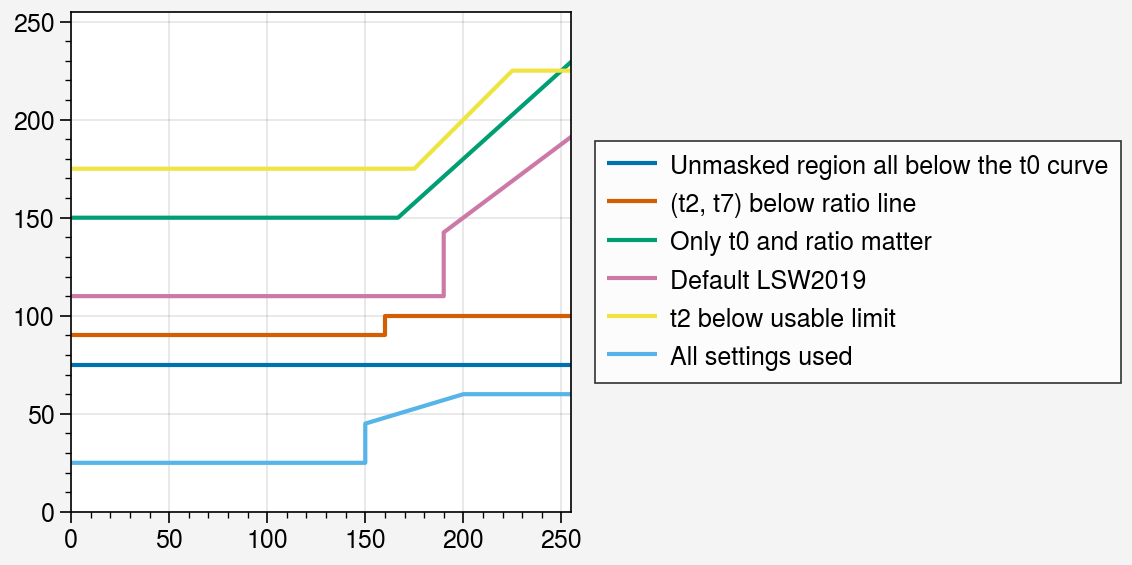

In [2]:
%run ../scripts/example_cloudmask_curves.py

For the updated version of the software, we have the option to either set new parameters for the LA2019 algorithm, or to develop a new version. For example, replacing step 5 by
$$ \text{Opaque clouds} \gets A \setminus (B \cup C) $$
changes the shape of the curve substantially (while being superficially consistent with the description in the LA2019 paper). We opt for choosing the best-performing version with the original logic.

The more stringent cloud mask improves the total cloud fraction, but also results in speckled images that could degrade performance further down in the algorithm. So we include a step to remove isolated groups of pixels using a diamond-shaped structuring element with radius 2.

6. Erode the opaque clouds with a structuring element SE
7. Use the eroded image to reconstruct the opaque clouds
8. Fill holes in the opaque clouds
9. Return the cloud mask after morphological cleanup

Some notes
- Not so easy to just grab the functions from the IFT library. 


## Updating the parameter choices
We use the Sea Ice Floe Validation Dataset to get information on the pixel intenstities for cloudy, clear-sky ice, and cloudy-sky ice pixels, and use the histograms derived from the pixel intensities to determine the cloud mask settings. 
We select 2/3 of the cases at random as the training dataset. We visualize and calibrate the initial algorithm and the candidate strict and permissive cloud masks with the histograms of training data, then compute the confusion matrices using the held-out data.

Running the calibration script loads the training and testing data.

I've set up something to load the old and new cloudmasks.

tau0=53.0, tau7=130.0, tau2=170.0, tau_r=0.52


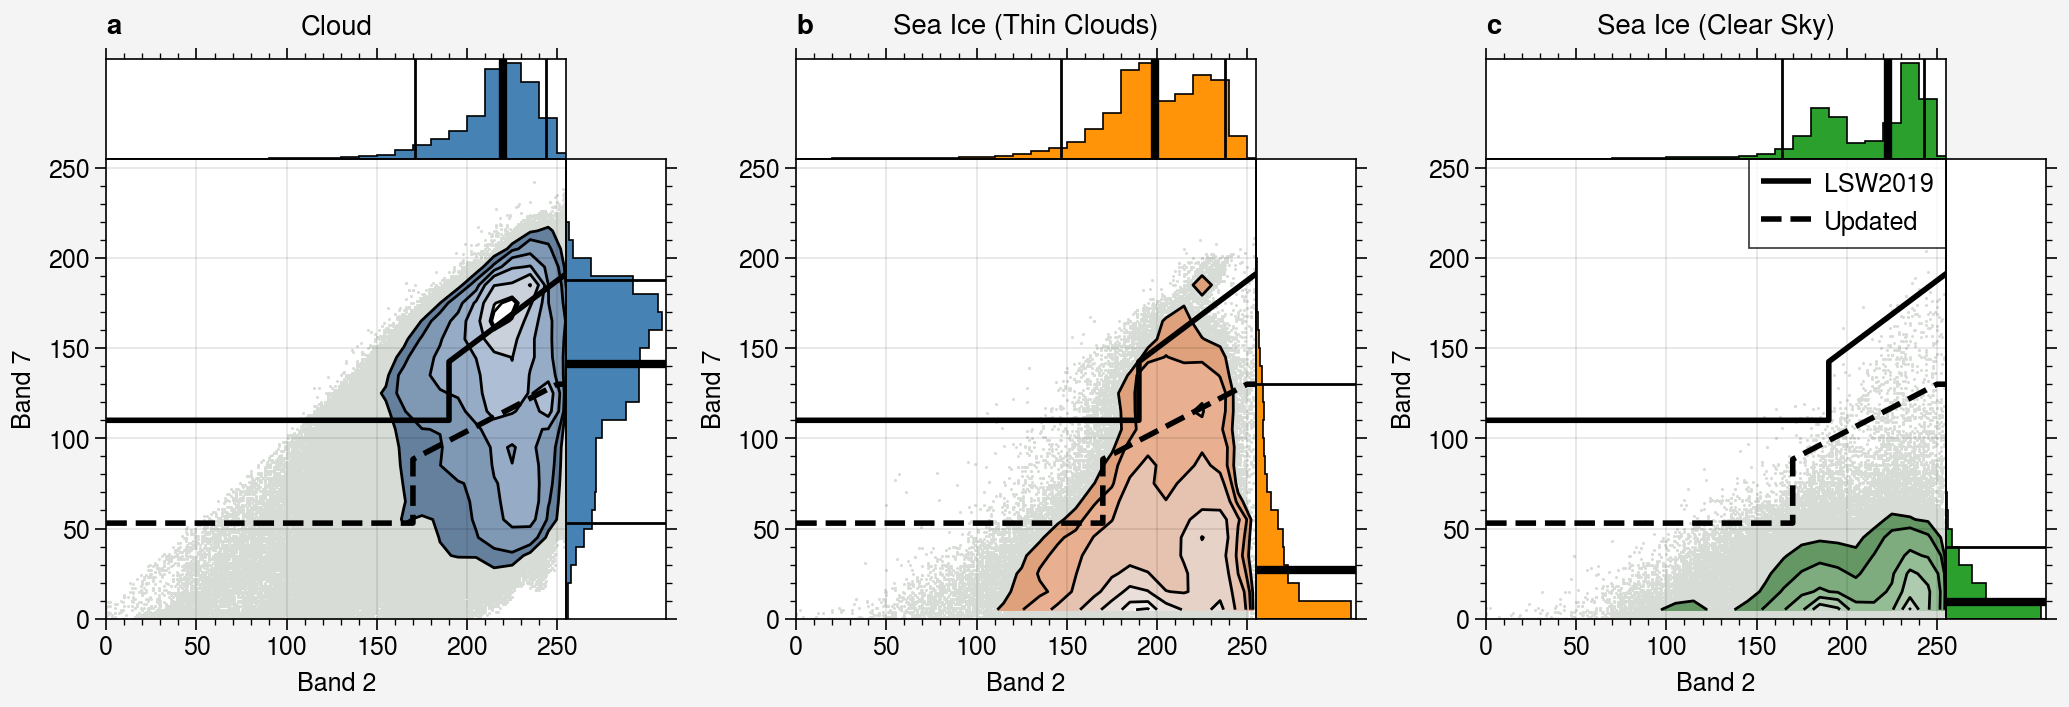

In [33]:
%run ../scripts/calibrate_cloudmask_plot_histograms.py

In [29]:
cloud_mask_new_cleaned

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 400, 400), dtype=uint8)

# Choosing parameters for the cloud mask
The choice of parameters for the ice mask has some freedom, shown by the range of shapes in the first figure in the notebook, and some strict limitations. One of the more limiting factors is that the ratio test has to go through the origin -- easily adjusted by adding offset term, which we have added into the code but will optimize at some future date. It's also not exactly obvious where one would want to try and optimize things. The following includes examination of a few methods, including the one we use in the end.

## 1. Marginal distributions only
Set a tolerance level for the fraction of the marginal distributions you want to include. That results, though, in a curve that omits some parts of the joint distribution in ways that feel somewhat artificial. An example of how that would work is to say we want to set the initial threshold to include 95\% of the cloudy pixels, so we set it to $\tau_0 = 53 = 95$th percentile for Cloudy B$_7$. Then we can look at trying to mark off 95\% of the cloudy ice pixels. But since this is a 2d distribution, there is not a unique way to do that. Choosing the 95th percentile for B$_7$ and the 5th percentile for $B_2$ leads to thresholds of 149 and 128, and an $R$ value of 0.62.

In [34]:
# t0 = 53
category = 'cloudy'
idx = pixel_data[category].training
t0 = pixel_data[category].loc[idx, 'b7'].quantile(0.05)

category = 'cloudy_ice'
idx = pixel_data[category].training
tau_b2 = pixel_data[category].loc[idx, 'b2'].quantile(0.05)
tau_b7 = pixel_data[category].loc[idx, 'b7'].quantile(0.95)
r = pixel_data[category].loc[idx, 'b7b2'].quantile(0.95)
print("tau0={t0}, tau7={t7}, tau2={t2}, tau_r={r}".format(t0=t0, t7=tau_b7, t2=tau_b2, r=np.round(r, 2)))

tau0=53.0, tau7=130.0, tau2=147.0, tau_r=0.62


In [39]:
pixel_data['cloudy_ice'].head()

b1     b2     b3     b4    b7  la2019_mask  dmw2025_mask      case  \
0  107.0   64.0  117.0  115.0   0.0          0.0           0.0  004_aqua   
1  103.0   67.0  114.0  113.0   0.0          0.0           0.0  004_aqua   
2  154.0  151.0  157.0  155.0  27.0          0.0           0.0  004_aqua   
3  157.0  140.0  162.0  161.0  19.0          0.0           0.0  004_aqua   
4  166.0  151.0  174.0  171.0  39.0          0.0           0.0  004_aqua   

       b7b2  training  
0  0.000000     False  
1  0.000000     False  
2  0.178808     False  
3  0.135714     False  
4  0.258278     False

In [ ]:
# Comparison to training data

In [52]:
print("True positive rate")
print(
    (pixel_data['cloudy'].loc[pixel_data['cloudy'].training,
        ['la2019_mask', 'dmw2025_mask']] > 0).mean())

print("False positive rate: cloudy ice")
print(
    (pixel_data['cloudy_ice'].loc[pixel_data['cloudy_ice'].training,
        ['la2019_mask', 'dmw2025_mask']] > 0).mean())

print("False positive rate: clear-sky ice")
print((pixel_data['clearsky_ice'].loc[pixel_data['clearsky_ice'].training,
    ['la2019_mask', 'dmw2025_mask']] > 0).mean())

print("False positive rate: clear and cloudy ice")
temp_df = pd.concat([pixel_data['clearsky_ice'], pixel_data['cloudy_ice']])
print((temp_df.loc[temp_df.training, ['la2019_mask', 'dmw2025_mask']] > 0).mean())

True positive rate
la2019_mask     0.346637
dmw2025_mask    0.737100
dtype: float64
False positive rate: cloudy ice
la2019_mask     0.024523
dmw2025_mask    0.090674
dtype: float64
False positive rate: clear-sky ice
la2019_mask     0.000056
dmw2025_mask    0.000540
dtype: float64
False positive rate: clear and cloudy ice
la2019_mask     0.007756
dmw2025_mask    0.028909
dtype: float64


In [53]:
print("True positive rate")
print(
    (pixel_data['cloudy'].loc[~pixel_data['cloudy'].training,
        ['la2019_mask', 'dmw2025_mask']] > 0).mean())

print("False positive rate: cloudy ice")
print(
    (pixel_data['cloudy_ice'].loc[~pixel_data['cloudy_ice'].training,
        ['la2019_mask', 'dmw2025_mask']] > 0).mean())

print("False positive rate: clear-sky ice")
print((pixel_data['clearsky_ice'].loc[~pixel_data['clearsky_ice'].training,
    ['la2019_mask', 'dmw2025_mask']] > 0).mean())

print("False positive rate: clear and cloudy ice")
temp_df = pd.concat([pixel_data['clearsky_ice'], pixel_data['cloudy_ice']])
print((temp_df.loc[~temp_df.training, ['la2019_mask', 'dmw2025_mask']] > 0).mean())

True positive rate
la2019_mask     0.349401
dmw2025_mask    0.729298
dtype: float64
False positive rate: cloudy ice
la2019_mask     0.042103
dmw2025_mask    0.072948
dtype: float64
False positive rate: clear-sky ice
la2019_mask     0.000005
dmw2025_mask    0.000957
dtype: float64
False positive rate: clear and cloudy ice
la2019_mask     0.011862
dmw2025_mask    0.021233
dtype: float64


The performance of this method isn't bad: 

In [35]:
print('Method: 95th Percentiles')

# Compare methods with training dataset
c_df = pixel_data['cloudy'].loc[pixel_data['cloudy'].training, :]
ci_df = pixel_data['cloudy_ice'].loc[pixel_data['cloudy_ice'].training, :]
csi_df = pixel_data['clearsky_ice'].loc[pixel_data['clearsky_ice'].training, :]
original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=t0, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=t0, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=t0, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)


print('True positive rate (cloudy images):',
      np.round(np.mean(original_mask), 2), '(Orig)',
      np.round(np.mean(new_mask), 2), '(New)')

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask), 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask), 2), '(New)')

print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask])), 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask])), 2), '(New)')

Method: 95th Percentiles
True positive rate (cloudy images): 0.35 (Orig) 0.64 (New)
False positive rate (cloudy ice):  0.02 (Orig) 0.06 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.01 (Orig) 0.02 (New)


So in a sense, this is a pretty clear and good result! We've increased the performance for cloudy regions, going from covering 35\% of cloudy pixels to 64\% of cloudy pixels, at a cost of masking 6\% of the cloud-obscured sea ice pixels. There was no significant change in the number of clear-sky ice pixels covered. Considering both the clear sky and cloudy ice pixels together, we've covered only 2\% of the sea ice pixels in the testing dataset.

One issue with this approach? The majority of the cloudy ice pixels are already set aside by the t0 threshold! Specifically, only 28\% of the cloudy ice pixels have B$_7$ reflectance greater than 53, and 1\% of the clear-sky ice pixels do. So the mask fitting was based on using data that never was covered in the first place.

In [8]:
tau_init = 110
tau_init = 53
idx = pixel_data['cloudy_ice'].training
y1 = pixel_data['cloudy_ice'].loc[idx, 'b7']

print('Fraction of cloudy ice pixels masked by Step 1 cloud mask: ', np.round(np.mean(y1 > tau_init)*100, 1), '%')
idx = pixel_data['clearsky_ice'].training
y2 = pixel_data['clearsky_ice'].loc[idx, 'b7']
print('Fraction of clear-sky ice pixels masked by Step 1 cloud mask: ', np.round(np.mean(y2 > tau_init)*100, 1), '%')

Fraction of cloudy ice pixels masked by Step 1 cloud mask:  28.2 %
Fraction of clear-sky ice pixels masked by Step 1 cloud mask:  1.4 %


## 2. Only data above $\tau_0$
If we were to use only the data above that original cloud mask, we could get something like this:

In [13]:
# Example using only pixels with b7 > tau_init
tau_init = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
idx = idx & (pixel_data[category]['b7'] > tau_init)
x = pixel_data[category].loc[idx, 'b2']
y = pixel_data[category].loc[idx, 'b7']
tau_b2 = x.quantile(0.05)
tau_b7 = y.quantile(0.95)
r = pixel_data[category].loc[idx, 'b7b2']
r = r.quantile(0.95)
print("tau0={t0}, tau7={t7}, tau2={t2}, tau_r={r}".format(t0=t0, t7=tau_b7, t2=tau_b2, r=np.round(r, 2)))

tau0=53.0, tau7=158.0, tau2=170.0, tau_r=0.76


In [10]:
original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):', np.round(np.mean(original_mask), 2), '(Orig)', np.round(np.mean(new_mask), 2), '(New)')

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask), 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask), 2), '(New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask])), 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask])), 2), '(New)')

True positive rate (cloudy images): 0.35 (Orig) 0.42 (New)
False positive rate (cloudy ice):  0.02 (Orig) 0.03 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.01 (Orig) 0.01 (New)


In this case, we still see an improvement with the cloud mask (42\% is better than 35\%!) and we dropped the false positive rate from 6\% to 3\%. So this approach degrades the cloud mask performance -- 64\% down to 42\% -- and only improves the uncovering performance by 3\%.

## 3. Hybrid method
Finally, let's look at a hybrid method: selecting the band 2 threshold based on 95\% of the cloudy ice pixels conditioned on the band 7 reflectance exceeding the initial threshold, but use all the cloudy ice data to set the band 7 unmasking threshold. Then set R using the band 2 and band 7 data where $B_2 > \tau_2$ and $B_7 > \tau_7.$

In [14]:
tau_init = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
idx_b2 = idx & (pixel_data[category]['b7'] > tau_init)
x = pixel_data[category].loc[idx_b2, 'b2']
y = pixel_data[category].loc[idx, 'b7']
tau_b2 = x.quantile(0.05)
tau_b7 = y.quantile(0.95)
idx_r = idx & (pixel_data[category]['b2'] > tau_b2) & (pixel_data[category]['b7'] < tau_b7)
r = pixel_data[category].loc[idx_r, 'b7b2']
r = r.quantile(0.95)
print("tau0={t0}, tau7={t7}, tau2={t2}, tau_r={r}".format(t0=t0, t7=tau_b7, t2=tau_b2, r=np.round(r, 2)))

tau0=53.0, tau7=130.0, tau2=170.0, tau_r=0.52


In [15]:
original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):', np.round(np.mean(original_mask), 2), '(Orig)', np.round(np.mean(new_mask), 2), '(New)')

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask), 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask), 2), '(New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask])), 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask])), 2), '(New)')

True positive rate (cloudy images): 0.35 (Orig) 0.73 (New)
False positive rate (cloudy ice):  0.02 (Orig) 0.11 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.01 (Orig) 0.03 (New)


# Summary (Training data)
Settings
| Method | $\tau_0$ | $\tau_7$ | $\tau_2$ | $\tau_r$ |
| --- | --- | --- | --- | --- |
| Original | 110 | 200 | 190 | 0.75 |
| 95% | 53 | 130 | 147 | 0.62 |
| Above | 53 | 157 | 169 | 0.76 |
| Hybrid | 53 | 130 | 170 | 0.52 |

Error metrics
| Method | TPR (cloudy) | FPR (cloudy ice) | FPR (clear-sky) | FPR (cloudy and clear ice) |
| --- |  --- |  --- |  --- |  --- |
| Original | 35% | 2% | 0% | 1% |
| 95\% | 64% | 6% | 0% | 2% |
| Above $t_0$ | 42% | 3% | 0% | 1% |
| Hybrid | 73% | 11% | 0% | 3% |

Other things we could examine: use of 99th percentile instead of 95th, use of morphological operators, etc.


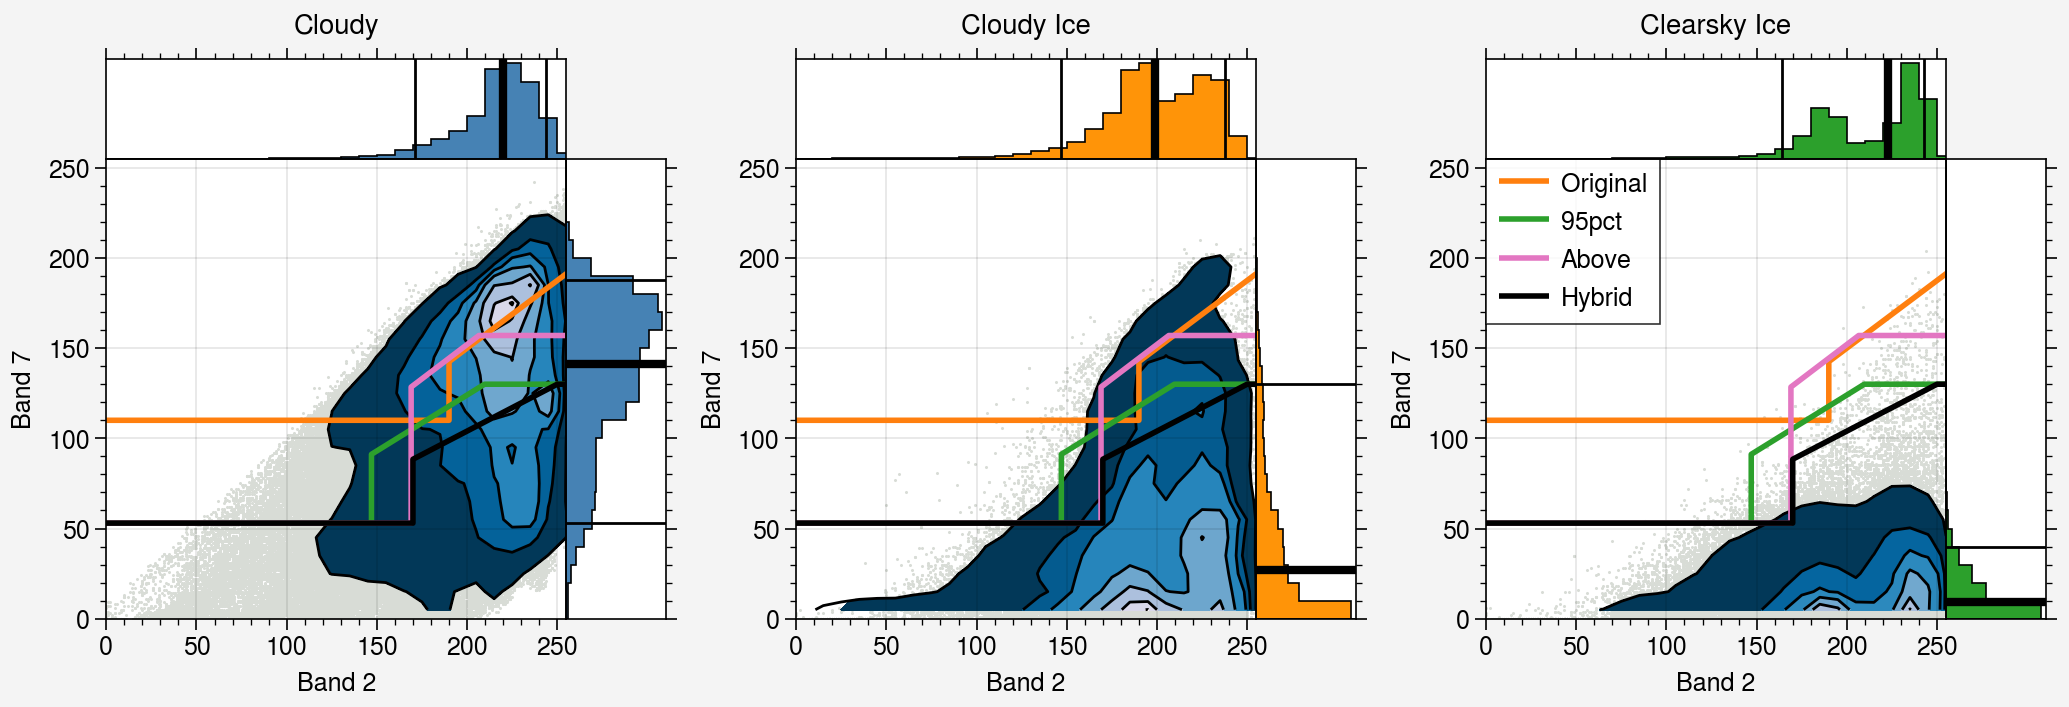

In [17]:
params = {'Original': {'tau_0': 110,
                       'tau_7': 200,
                       'tau_2': 190,
                       'tau_r': 0.75,
                       'c': 'tab:orange'},
          '95pct': {'tau_0': 53,
                       'tau_7': 130,
                       'tau_2': 147,
                       'tau_r': 0.62,
                       'c': 'tab:green'},
          'Above': {'tau_0': 53,
                       'tau_7': 157,
                       'tau_2': 169,
                       'tau_r': 0.76,
                       'c': 'tab:pink'},
          'Hybrid': {'tau_0': 53,
                       'tau_7': 130,
                       'tau_2': 170,
                       'tau_r': 0.52,
                        'c': 'k'}}
          


from scipy.interpolate import interp1d

fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

for ax, category, color in zip(axs, ['cloudy', 'cloudy_ice', 'clearsky_ice'], ['steelblue', 'tangerine', 'tab:green']):

    idx = pixel_data[category].training
    x = pixel_data[category].loc[idx, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    x.name = 'Band 2' # weirdly the xlabel function isn't working at all
    y.name = 'Band 7'
    
    bins = np.arange(0, 261, 10)
    binc = 0.5*(bins[1:] + bins[:-1])
    H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
    H = H.T

    Hd = H/np.sum(H)
    F = np.linspace(0, np.max(Hd), 50)
    L = [1-np.sum(Hd[Hd > f]) for f in F]
    results = pd.Series(L, index=F)
    results = results.loc[~results.duplicated()]
    
    # pctiles = np.linspace(0, 1, 11)
    # levels = np.quantile(np.ravel(H)[np.ravel(H) > 0], np.linspace(0, 1, 11))
    # idx2 = levels > 0
    # print(pctiles[idx2])
    # levels = levels[idx2]
    pct = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
    levels = interp1d(results, results.index)(pct)
    levels = [x for x in levels] + [np.max(Hd)]
    ax.scatter(x.values, y.values, ms=1, m='.', color='light gray')
    # ax.pcolormesh(binc, binc, np.ma.masked_array(H, H==0), N=10, cmap='PuBu_r')
    ax.contourf(binc, binc, np.ma.masked_array(Hd, Hd == 0),
              levels=levels, cmap='PuBu_r', alpha=1)
    #          , colorbar='b', colorbar_kw={'label': 'Count', 'rotation': 45})
    ax.contour(binc, binc, Hd, vmin=0, vmax=np.max(Hd),
               levels=levels, lw=1, color='k')
  
    ax.format(titleabove=True,
              title=category.replace('_', ' ').title(),
              ylim=(0, 255), xlim=(0, 255),
              xlabel='Band 2')
    py = ax.panel('r', space=0)
    py.histh(y, bins, color=color, fill=True, ec='k')

    px = ax.panel('t', space=0)
    px.hist(x, bins, color=color, fill=True, ec='k')
    
    pctiles = [0.05, 0.5, 0.95]
    lwidth = [1, 3, 1]
    for p, l in zip(pctiles, lwidth):
        py.axhline(y.quantile(p), lw=l, color='k')
        px.axvline(x.quantile(p), lw=l, color='k')
        
    py.format(grid=False, xlocator=[], ylabel='Band 7', xlabel='', xreverse=False)
    px.format(grid=False, ylocator=[])

for ax in axs:
    for method in params:
        x, y = draw_mask(t0=params[method]['tau_0'],
                         t2=params[method]['tau_2'],
                         t7=params[method]['tau_7'],
                         r_upper=params[method]['tau_r'])
        ax.plot(x, y, label=method, ls='-', lw=2, color=params[method]['c'])

ax.legend(ncols=1)
fig.save('../figures/cloud_mask_histograms_alt_methods_demo.png', dpi=300)

# Validate with held-out data
For the validation, we need to use the masks created using the IFT algorithm, including the morphological cleanup. The `create_cloudmask_images.jl` script produces these images.

* Will need to add the la2019 and the new cm as columns in the pixel_data dict
* 

In [25]:
cloud_mask_original

{}

In [161]:
tau_init = 53
tau_b7 = 130
tau_b2 = 169
r = 0.53

# Compare methods with training dataset
c_df = pixel_data['cloudy'].loc[~pixel_data['cloudy'].training, :]
ci_df = pixel_data['cloudy_ice'].loc[~pixel_data['cloudy_ice'].training, :]
csi_df = pixel_data['clearsky_ice'].loc[~pixel_data['clearsky_ice'].training, :]

original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):',
      np.round(np.mean(original_mask)*100, 2), '% (Orig)',
      np.round(np.mean(new_mask)*100, 2), '% (New)')

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask)*100, 2), '% (Orig)',
      np.round(np.mean(cloud_ice_new_mask)*100, 2), '% (New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask)*100, 2), '% (Orig)',
      np.round(np.mean(clearsky_ice_new_mask)*100, 2), '% (New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask]))*100, 2), '% (Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask]))*100, 2), '% (New)')

True positive rate (cloudy images): 34.97 % (Orig) 72.45 % (New)
False positive rate (cloudy ice):  4.21 % (Orig) 7.76 % (New)
False positive rate (clear-sky ice):  0.0 % (Orig) 0.12 % (New)
False positive rate (cloudy ice + clear-sky ice):  1.26 % (Orig) 2.41 % (New)


# Illustrations of cloud mask functionality

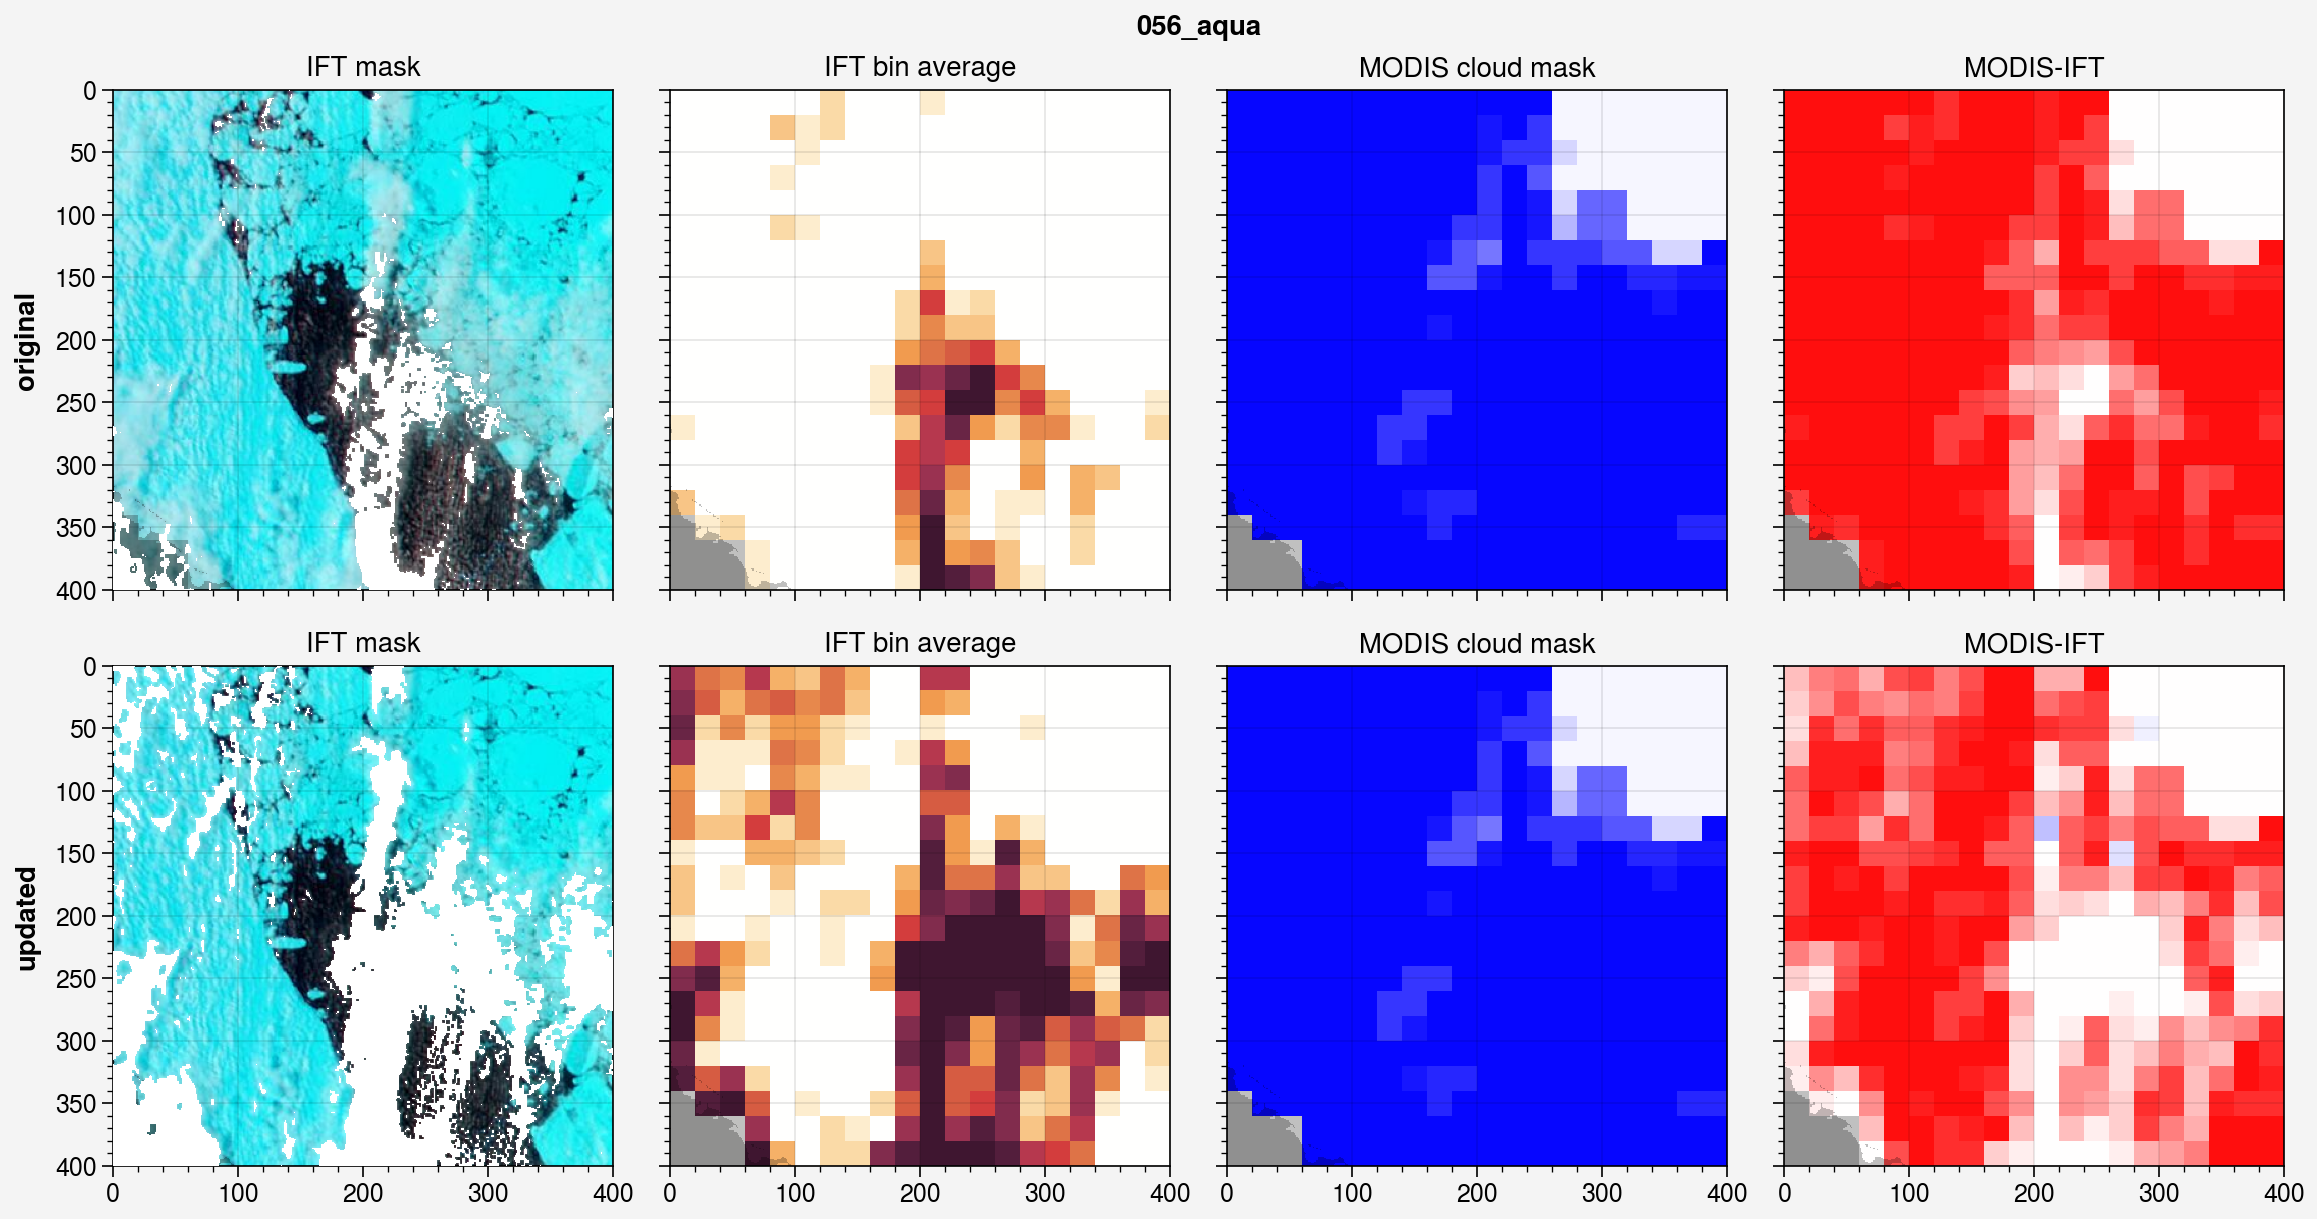

In [175]:
fig, axs = pplt.subplots(ncols=4, nrows=2)
axs.format(leftlabels=['original', 'updated'])

# assumes A is square! and that 20 evenly divides the shape

# Case 011: One where MODIS misclassifies ice ans cloud
case = '011_aqua'

# Case 104: IFT cloud mask is still fairly liberal (doesn't cover much), and the MODIS cloud mask covers many floes
case = '104_terra'

# Case 162: Fully cloud covered. IFT allows too much to stay uncovered.
case = '162_aqua'

# Case 066: Fully cloud covered. IFT update improves the cloud coverage.
case = '066_terra'

# Case 063: Thin clouds over clearly visible ice floes. Both versions of IFT do fine.
case = '063_aqua'

case = '056_aqua'

original = create_cloudmask(fc_images[case], t0=110, t_b7=200, t_b2=190, r_upper=0.75)
updated = create_cloudmask(fc_images[case], t0=53, t_b7=130, t_b2=169, r_upper=0.53)

for ax, ift_est in zip([axs[0,:], axs[1,:]], [original, updated]):

    land = lm_images[case].squeeze() > 0
    A = ift_est.astype(int)
    n = A.shape[0]
    m = int(n/20)
    # reshapes to dimension (80, 20, 80, 20)
    Lmean = land.astype(int).reshape([m, n//m, m, n//m]).mean(3).mean(1)
    Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    Amean = np.ma.masked_array(Amean, mask=Lmean > 0.5)
    bin_edges = np.linspace(0, 100, 17)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    ift_vec = np.ravel(Amean*100)
    ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
    ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
    binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)
    CF = np.ma.masked_array(cf_images[case].values[::20, ::20], mask=Lmean > 0.5)
    
    
    
    ax[0].imshow(reshape_as_image(fc_images[case]), extent=[0, 400, 400, 0])
    ax[0].imshow(np.ma.masked_array(A, A==0), c='w', extent=[0, 400, 400, 0], zorder=10)
    ax[1].imshow(binned_ift, extent=[0, 400, 400, 0])
    ax[2].imshow(CF, extent=[0, 400, 400, 0], vmin=-100, vmax=100, cmap='bwr_r')
    ax[3].imshow(CF - binned_ift, vmin=-100, vmax=100, cmap='bwr',
                extent=[0, 400, 400, 0])
    for ax0 in ax:
        ax0.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', alpha=0.25, extent=[0, 400, 400, 0])
        ax0.imshow(np.ma.masked_array(Lmean, Lmean < 0.5), color='k', alpha=0.25, extent=[0, 400, 400, 0])
    ax[0].format(title='IFT mask'.format(tc=tc))
    ax[1].format(title='IFT bin average')
    ax[2].format(title='MODIS cloud mask')
    ax[3].format(title='MODIS-IFT')
axs.format(suptitle=case)

In [176]:
### These functions let us look at MSE between IFT and MODIS if needed

def get_binned_ift_est(fc, tc_threshold):
    """Computes a 5 km average of the IFT data and bins it into the
    same resolution as the MODIS cloud fraction data."""
    ift_est = fc > tc_threshold
    
    A = ift_est.astype(int)
    n = A.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    
    bin_edges = np.linspace(0, 100, 17)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    ift_vec = np.ravel(Amean*100)
    ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
    ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
    binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)

    return binned_ift

def get_binned_landmask(lm, lm_threshold=0.5):
    """Bins the land mask value and returns boolean array where True if land is greater than 50%"""
    L = (lm == 0).astype(int)
    n = L.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Lmean = L.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    return Lmean > lm_threshold

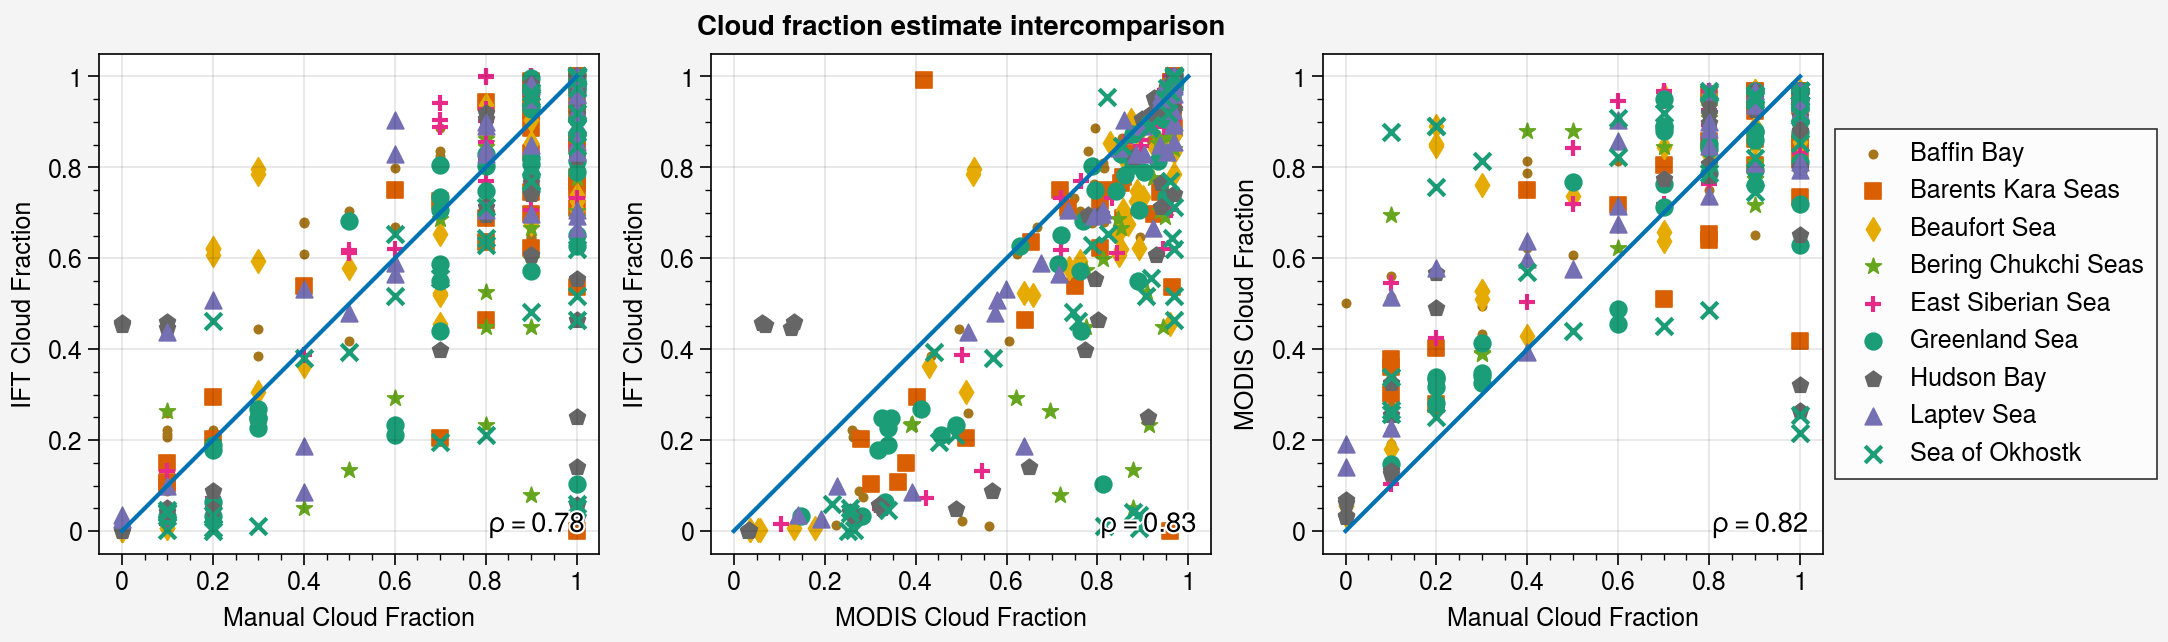

In [177]:
# Rough comparison between the estimates
# Note: the land pixels are included! The IFT cloud mask is not intended for those cases.
regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for case in fc_images:
    clouds_view, cloud_mask = generate_masks(fc_images[case], t0=53, t7=130, t2=169, r_upper=0.53)
    df.loc[case, 'ift_est'] = np.mean(clouds_view)
    
fig, axs = pplt.subplots(ncols=3, share=False)
for ax, col in zip(axs, ['cloud_fraction_manual', 'cloud_fraction_modis']):
    for region, group in df.groupby('region'):
    
        ax.scatter(group[col], group['ift_est'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
    
    ax.plot([0, 1], [0, 1])
    ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='IFT Cloud Fraction')
    ax.format(lrtitle='$\\rho=$' + str(np.round(df[col].corr(df['ift_est']), 2)))

axs[0].format(xlabel='Manual Cloud Fraction')
axs[1].format(xlabel='MODIS Cloud Fraction')

for region, group in df.groupby('region'):
    axs[2].scatter(group['cloud_fraction_manual'], group['cloud_fraction_modis'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
axs[2].plot([0, 1], [0, 1])
axs[2].format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='MODIS Cloud Fraction', xlabel='Manual Cloud Fraction')
axs[2].format(lrtitle='$\\rho=$' + str(np.round(df['cloud_fraction_manual'].corr(df['cloud_fraction_modis']), 2)))

axs[2].legend(loc='r', ncols=1)    

axs.format(suptitle='Cloud fraction estimate intercomparison')

fig.save('../figures/comparison_cloud_estimates.png', dpi=300)

# Visualization to examine cases
- 12 cases randomly selected from each division
- Overlay the pixels selected for the training data for each case
- Also look at which pixels get masked by the original cloud mask

In [179]:
# cloudy cases
# Cases that are 90% cloudy, part of our training data, and 
cloud_data = pixel_data['cloudy'].loc[pixel_data['cloudy'].training].groupby('case').filter(lambda x: len(x) > 0.9*400**2)
cloudy_cases_test = list(np.random.choice(cloud_data.case.unique(), 12, replace=False))

cloudy_ice_data = pixel_data['cloudy_ice'].loc[pixel_data['cloudy_ice'].training].groupby('case').filter(lambda x: len(x) > 50**2)
cloudy_ice_data = cloudy_ice_data.loc[[x for x in cloudy_ice_data.index if cloudy_ice_data.loc[x, 'case'] not in cloudy_cases_test]]
cloudy_ice_cases_test = list(np.random.choice(cloudy_ice_data.case.unique(), 12, replace=False))

clearsky_ice_data = pixel_data['clearsky_ice'].loc[pixel_data['clearsky_ice'].training].groupby('case').filter(lambda x: len(x) > 100**2)
clearsky_ice_data = clearsky_ice_data.loc[[x for x in clearsky_ice_data.index if clearsky_ice_data.loc[x, 'case'] not in cloudy_ice_cases_test]]
clearsky_ice_cases_test = list(np.random.choice(clearsky_ice_data.case.unique(), 12, replace=False))

In [185]:
#### Plot images with no overlays #####
for title, cases in zip(['cloudy', 'cloudy_ice', 'clearsky_ice'], [cloudy_cases_test, cloudy_ice_cases_test, clearsky_ice_cases_test]):
    fig, axs = pplt.subplots(nrows=3, ncols=4)
    for ax, case in zip(axs, cases):
        ax.imshow(reshape_as_image(fc_images[case]))
        ax.format(title=case)
    ax.format(suptitle='{t} Case Examples'.format(t=title.replace('_', ' ').title()))
    fig.save('../figures/example_{t}_cases.png'.format(t=title), dpi=300)
    pplt.close(fig)

In [186]:
#### Overlay masks, IFT original mask
for title, cases in zip(['cloudy', 'cloudy_ice', 'clearsky_ice'], [cloudy_cases_test, cloudy_ice_cases_test, clearsky_ice_cases_test]):
    fig, axs = pplt.subplots(nrows=3, ncols=4)
    for ax, case in zip(axs, cases):
        
        ax.imshow(reshape_as_image(fc_images[case]), zorder=0)
        
        land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
        ax.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', zorder=1)

        if case in lb_images:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            ice_pixels = ice_floes | fast_ice
            ax.imshow(np.ma.masked_array(ice_pixels, mask=~ice_pixels), c='gray0', zorder=3)

        modis_mask = cf_images[case] > 20
        ax.imshow(np.ma.masked_array(modis_mask.astype(int), mask=~modis_mask), vmin=0, vmax=1, c='gold', alpha=0.5, zorder=4)
        
        clouds_view, cloud_mask = generate_masks(fc_images[case])
        ax.imshow(np.ma.masked_array(clouds_view.astype(int), mask=~clouds_view), vmin=0, vmax=1, c='r', alpha=0.5, zorder=5)
  
        ax.format(title=case)

        h = [ax.plot([],[], m='s', lw=0, color='gold'),
        ax.plot([],[], m='s', lw=0, color='r'),
        ax.plot([],[], m='s', lw=0, color='gray0')
        ]
        ax.legend(h, ['MODIS Cloud', 'IFT Cloud', 'Ice'], ncol=1, alpha=1)
        
    ax.format(suptitle='{t} Case Examples (Original IFT Cloud Mask)'.format(t=title.replace('_', ' ').title()))
    fig.save('../figures/example_ift_{t}_cases_orig.png'.format(t=title), dpi=300)
    pplt.close(fig)

In [187]:
#### Overlay masks, IFT original mask
for title, cases in zip(['cloudy', 'cloudy_ice', 'clearsky_ice'], [cloudy_cases_test, cloudy_ice_cases_test, clearsky_ice_cases_test]):
    fig, axs = pplt.subplots(nrows=3, ncols=4)
    for ax, case in zip(axs, cases):
        
        ax.imshow(reshape_as_image(fc_images[case]), zorder=0)
        
        land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
        ax.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', zorder=1)

        if case in lb_images:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            ice_pixels = ice_floes | fast_ice
            ax.imshow(np.ma.masked_array(ice_pixels, mask=~ice_pixels), c='gray0', zorder=3)

        modis_mask = cf_images[case] > 20
        ax.imshow(np.ma.masked_array(modis_mask.astype(int), mask=~modis_mask), vmin=0, vmax=1, c='gold', alpha=0.5, zorder=4)
        
        clouds_view, cloud_mask = generate_masks(fc_images[case], t0=53, t7=130, t2=169, r_upper=0.53)
        ax.imshow(np.ma.masked_array(clouds_view.astype(int), mask=~clouds_view), vmin=0, vmax=1, c='r', alpha=0.5, zorder=5)
  
        ax.format(title=case)

        h = [ax.plot([],[], m='s', lw=0, color='gold'),
        ax.plot([],[], m='s', lw=0, color='r'),
        ax.plot([],[], m='s', lw=0, color='gray0')
        ]
        ax.legend(h, ['MODIS Cloud', 'IFT Cloud', 'Ice'], ncol=1, alpha=1)
        
    ax.format(suptitle='{t} Case Examples (Updated IFT Cloud Mask)'.format(t=title.replace('_', ' ').title()))
    fig.save('../figures/example_ift_{t}_cases_updated.png'.format(t=title), dpi=300)
    pplt.close(fig)